In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [3]:
USE_CUDA = False

In [4]:
Timeseries = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Time series/Rossler_stochastic_weighted_intensity01.csv',encoding='utf-8',header=None)

In [5]:
Adj = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/rossler_weighted_adj.csv',encoding='utf-8',header=None)

In [6]:
EDGES = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/rossler_weighted_edgelist.csv',encoding='utf-8',header=None)

In [7]:
W = EDGES.iloc[:,2].values

In [8]:
W = W.reshape((-1,1))

In [9]:
W = torch.from_numpy(W)

In [10]:
W.shape

torch.Size([80, 1])

In [11]:
Num_nodes = 20
Dimension = 3

In [12]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [13]:
delt_t = 0.01

In [14]:
timeseries_t0 = timeseries[:-2,:,:]
timeseries_t1 = timeseries[1:-1,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [15]:
data = np.concatenate((timeseries[:-2,:,:],dXdt),axis=2)

In [16]:
data.shape

(19999, 20, 6)

In [17]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [18]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [19]:
import numpy as np
goal_data = data[1:-1,:,0:Dimension]
mapping_data = data[0:-2,:,0:Dimension]

In [20]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [21]:
X.size()

torch.Size([19997, 20, 3])

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [24]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [25]:
aggr = 'add'
hidden = 100
model = 'Rossler'

msg_dim = 1
n_f = mapping_data.shape[2]

In [26]:
dim = Dimension*1

In [27]:
from torch_geometric.data import Data, DataLoader

In [28]:
ogn = SDIweighted(model,n_f, msg_dim, dim, delt_t, W, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [29]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []
ogn = ogn

In [30]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [31]:
ogn.loss(_q)

tensor(1.7485, dtype=torch.float64, grad_fn=<AddBackward0>)

In [34]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

In [35]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [37]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

total_epochs = 50

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

In [38]:
epoch = 0
from tqdm import tqdm

In [39]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
# newtestloader = DataLoader(
#      [Data(
#          X_test[i],
#          edge_index=edge_index,
#          y=y_test[i]) for i in test_idxes],
#      batch_size=len(X_test),
#      shuffle=False
#  )

newtestloader = DataLoader(
     [Data(
         X_train[i],
         edge_index=edge_index,
         y=y_train[i]) for i in test_idxes],
     batch_size=len(X_train),
     shuffle=False)

In [40]:
test_idxes.shape

(1000,)

In [41]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        #print(s1)
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        #print(s2)
        Tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        Tmp = Tmp.reshape(2,-1)
        Tmp = Tmp.t()# tmp has shape [E, 2 * in_channels]
        Len = int(s1.shape[0])/int(W.shape[0])
        w = W.repeat(int(Len),1)
        
        tmpW = torch.cat([Tmp,w],dim=1)
        tmpW = tmpW.to(torch.float32)
        #source_x = tmp.x[tmp.edge_index[1]]
        #tmpW = torch.cat([Tmp,source_x[:,Dimension].reshape(source_x.shape[0],1)],dim=1)
        #print(tmp)
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(Tmp)*w#/source_x[:,Dimension].reshape(source_x.shape[0],1)

        all_messages = torch.cat((
            tmpW,
             m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['w']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['w']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['w']
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [42]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        #tmp = tmp[:,0:Dimension].reshape(-1,Dimension)
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_z = ogn.node_fnc_z(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y,self_dyn_z), dim=1)
            columns = ['x','y','z','s1','s2','s3']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info        

In [43]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['x','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['x','y','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['x','y','z','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [44]:
recorded_models = []

In [45]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)


    cur_loss = total_loss/num_items 
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())

  0%|                                                    | 0/50 [00:00<?, ?it/s]

-0.01878150330681134


  2%|▊                                         | 1/50 [01:29<1:12:59, 89.39s/it]

-0.09789003215320778


  4%|█▋                                        | 2/50 [02:57<1:10:47, 88.50s/it]

-0.13894173675923838


  6%|██▌                                       | 3/50 [04:25<1:09:03, 88.17s/it]

-0.14932164521233723


  8%|███▎                                      | 4/50 [05:52<1:07:31, 88.07s/it]

-0.1524586103878422


 10%|████▏                                     | 5/50 [07:21<1:06:04, 88.10s/it]

-0.153194820647123


 12%|█████                                     | 6/50 [08:49<1:04:40, 88.19s/it]

-0.15301546177728528


 14%|█████▉                                    | 7/50 [10:17<1:03:12, 88.20s/it]

-0.15206231657300606


 16%|██████▋                                   | 8/50 [11:46<1:01:46, 88.26s/it]

-0.1519209472481691


 18%|███████▌                                  | 9/50 [13:14<1:00:19, 88.29s/it]

-0.15137483579313118


 20%|████████▌                                  | 10/50 [14:42<58:50, 88.25s/it]

-0.15243012817917914


 22%|█████████▍                                 | 11/50 [16:10<57:18, 88.18s/it]

-0.15272711363023658


 24%|██████████▎                                | 12/50 [17:38<55:48, 88.11s/it]

-0.15429818225715342


 26%|███████████▏                               | 13/50 [19:06<54:18, 88.07s/it]

-0.15623774728101122


 28%|████████████                               | 14/50 [20:34<52:47, 87.98s/it]

-0.15747966418276912


 30%|████████████▉                              | 15/50 [22:02<51:16, 87.91s/it]

-0.15871289546252343


 32%|█████████████▊                             | 16/50 [23:29<49:46, 87.85s/it]

-0.1591571953310751


 34%|██████████████▌                            | 17/50 [24:57<48:18, 87.83s/it]

-0.15960214104558354


 36%|███████████████▍                           | 18/50 [26:25<46:48, 87.76s/it]

-0.1596993685446623


 38%|████████████████▎                          | 19/50 [27:52<45:18, 87.70s/it]

-0.1597906721366711


 40%|█████████████████▏                         | 20/50 [29:20<43:51, 87.70s/it]

-0.1598592804105926


 42%|██████████████████                         | 21/50 [30:47<42:21, 87.66s/it]

-0.15990942147303705


 44%|██████████████████▉                        | 22/50 [32:15<40:52, 87.58s/it]

-0.15997955861597837


 46%|███████████████████▊                       | 23/50 [33:43<39:25, 87.60s/it]

-0.16002070268218416


 48%|████████████████████▋                      | 24/50 [35:10<37:55, 87.52s/it]

-0.16005035789875144


 50%|█████████████████████▌                     | 25/50 [36:37<36:27, 87.49s/it]

-0.1600793712527175


 52%|██████████████████████▎                    | 26/50 [38:05<34:59, 87.49s/it]

-0.16012969292776255


 54%|███████████████████████▏                   | 27/50 [39:32<33:31, 87.44s/it]

-0.1601602388844418


 56%|████████████████████████                   | 28/50 [40:59<32:03, 87.42s/it]

-0.16018880223270995


 58%|████████████████████████▉                  | 29/50 [42:27<30:36, 87.46s/it]

-0.16020935836466418


 60%|█████████████████████████▊                 | 30/50 [43:54<29:08, 87.40s/it]

-0.16026048695100947


 62%|██████████████████████████▋                | 31/50 [45:21<27:39, 87.34s/it]

-0.16027221312604228


 64%|███████████████████████████▌               | 32/50 [46:49<26:11, 87.29s/it]

-0.16029757541326262


 66%|████████████████████████████▍              | 33/50 [48:16<24:43, 87.27s/it]

-0.16033333113224485


 68%|█████████████████████████████▏             | 34/50 [49:43<23:15, 87.24s/it]

-0.16035962942057128


 70%|██████████████████████████████             | 35/50 [51:10<21:49, 87.29s/it]

-0.1603843796702408


 72%|██████████████████████████████▉            | 36/50 [52:38<20:21, 87.23s/it]

-0.16041479579519047


 74%|███████████████████████████████▊           | 37/50 [54:05<18:53, 87.20s/it]

-0.16043971539924237


 76%|████████████████████████████████▋          | 38/50 [55:32<17:26, 87.17s/it]

-0.1604649357647397


 78%|█████████████████████████████████▌         | 39/50 [56:59<16:00, 87.33s/it]

-0.16049138782629457


 80%|██████████████████████████████████▍        | 40/50 [58:27<14:32, 87.27s/it]

-0.16051571932091319


 82%|███████████████████████████████████▎       | 41/50 [59:54<13:05, 87.25s/it]

-0.16053493041611852


 84%|██████████████████████████████████▍      | 42/50 [1:01:21<11:37, 87.25s/it]

-0.16056083017003828


 86%|███████████████████████████████████▎     | 43/50 [1:02:48<10:10, 87.23s/it]

-0.16057229324633446


 88%|████████████████████████████████████     | 44/50 [1:04:15<08:43, 87.21s/it]

-0.16059053363257625


 90%|████████████████████████████████████▉    | 45/50 [1:05:43<07:16, 87.21s/it]

-0.16060160423625885


 92%|█████████████████████████████████████▋   | 46/50 [1:07:10<05:49, 87.36s/it]

-0.16061486916243228


 94%|██████████████████████████████████████▌  | 47/50 [1:08:38<04:22, 87.40s/it]

-0.16062347828913512


 96%|███████████████████████████████████████▎ | 48/50 [1:10:05<02:54, 87.37s/it]

-0.16062831967598126


 98%|████████████████████████████████████████▏| 49/50 [1:11:32<01:27, 87.33s/it]

-0.1606319532739261


100%|█████████████████████████████████████████| 50/50 [1:13:00<00:00, 87.60s/it]


In [46]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)

In [47]:
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)

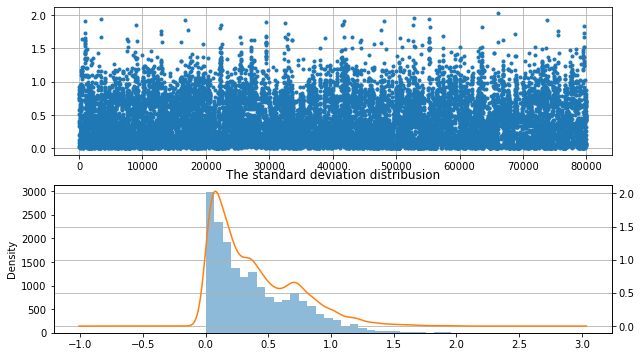

In [48]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(delt_t) # diffusion is sqrt(h)*theta(x0) 

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)
#ax1.scatter(s.index, s.values)
ax1.plot(s.index, s.values,'.')
plt.grid()
 
ax2 = fig.add_subplot(2,1,2) 
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.title('The standard deviation distribusion')
plt.grid()

In [49]:
s = diffusion_new['d1']/np.sqrt(delt_t)
s1 = (diffusion['x'].abs())*0.1 
s2 = diffusion_new['d2']/np.sqrt(0.01)
s3 = (diffusion['y'].abs())*0.1 
s4 = diffusion_new['d3']/np.sqrt(0.01)
s5 = (diffusion['z'].abs())*0.1 

In [51]:
import seaborn as sns
import numpy as np
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
 
sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )
np.random.seed(1425)

<AxesSubplot:xlabel='d3', ylabel='Density'>

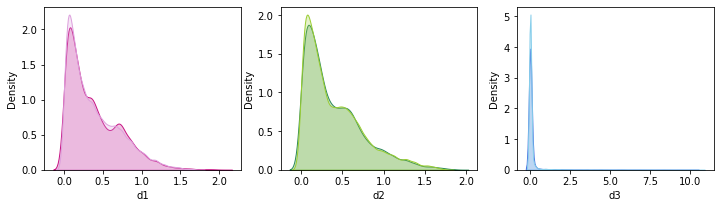

In [52]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(12, 3))
c1, c2, c3 = sns.color_palette('Set1', 3)


sns.kdeplot(s, shade=True, color=colors['mediumvioletred'], label='dist1', ax=ax1)
sns.kdeplot(s2, shade=True, color=colors['seagreen'], label='dist1', ax=ax2)
sns.kdeplot(s4, shade=True, color=colors['royalblue'], label='dist1', ax=ax3)
sns.kdeplot(s1, shade=True, color=colors['plum'], label='dist2',ax=ax1)
sns.kdeplot(s3, shade=True, color=colors['yellowgreen'], label='dist2',ax=ax2)
sns.kdeplot(s5, shade=True, color=colors['skyblue'], label='dist2',ax=ax3)

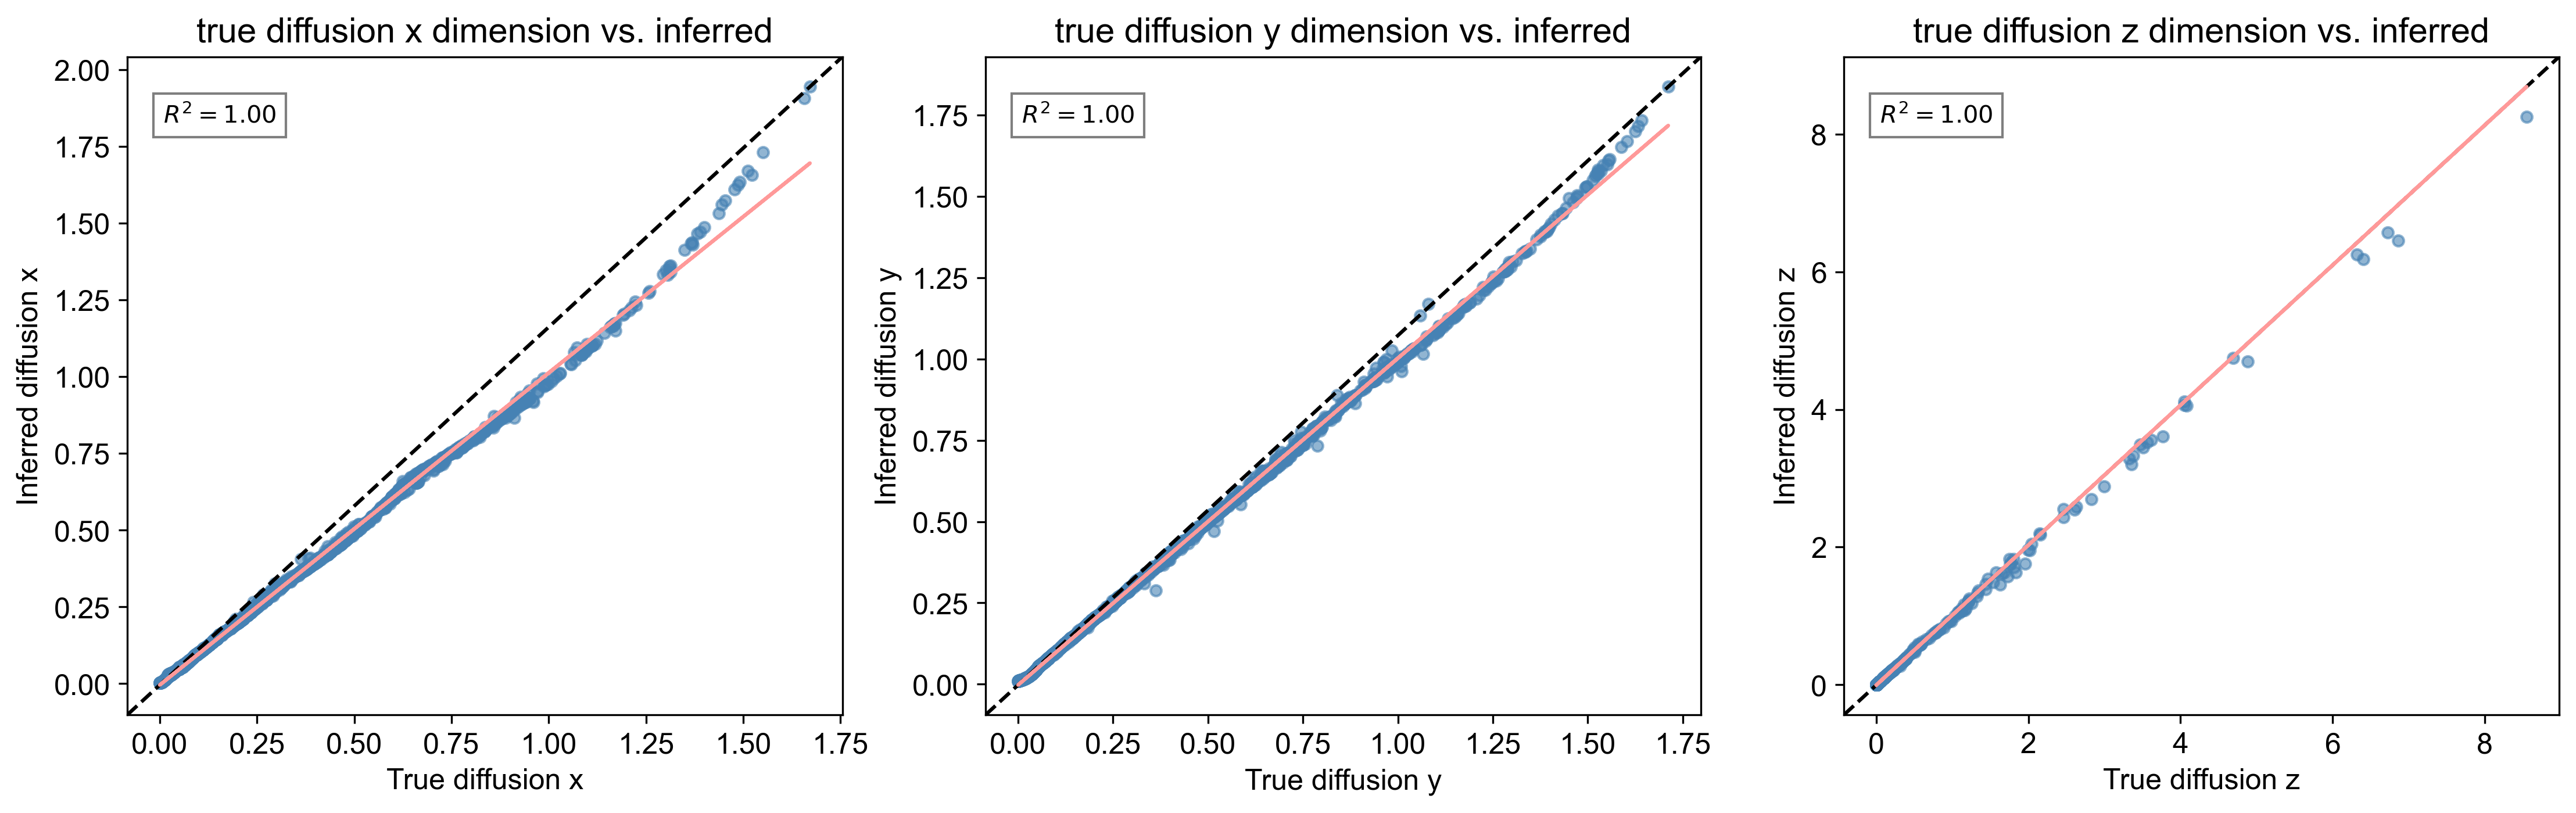

In [53]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
#import seaborn as sb
eta = 0.1
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
sx = diffusion['d1'].values/np.sqrt(0.01)
sx_true = np.abs(diffusion['x'].values)*eta
sy = diffusion['d2'].values/np.sqrt(0.01)
sy_true = np.abs(diffusion['y'])*eta
sz = diffusion['d3'].values/np.sqrt(0.01)
sz_true = np.abs(diffusion['z'])*eta

sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true diffusion x dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c = '#ff9999', lw=1.5)

ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion x")
plt.ylabel("Inferred diffusion x")
#plt.xlim((0, 2))
#plt.ylim((0, 2))
ax2 = fig.add_subplot(1,3,2)
plt.title("true diffusion y dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c = '#ff9999', lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion y")
plt.ylabel("Inferred diffusion y")
#plt.xlim((0, 2))
#plt.ylim((0, 2))
ax3 = fig.add_subplot(1,3,3)
plt.title("true diffusion z dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fx(sz_true),c = '#ff9999', lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion z")
plt.ylabel("Inferred diffusion z")
#plt.xlim((0, 5))
#plt.ylim((0, 5))
#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_diffusion.png')
plt.show()
plt.close()

In [54]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [55]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
for i in range(X.shape[0]):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp, y_tmp, z_tmp = ogn.average_trajectories(_q)
    X_tmp = torch.cat((x_tmp,y_tmp,z_tmp), 1)
    if i < X.shape[0]-2:
        X[i+1] = X_tmp
    else:
        break
    x_Update.append(x_tmp.reshape(1,-1))
    y_Update.append(y_tmp.reshape(1,-1))
    z_Update.append(z_tmp.reshape(1,-1))   
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)

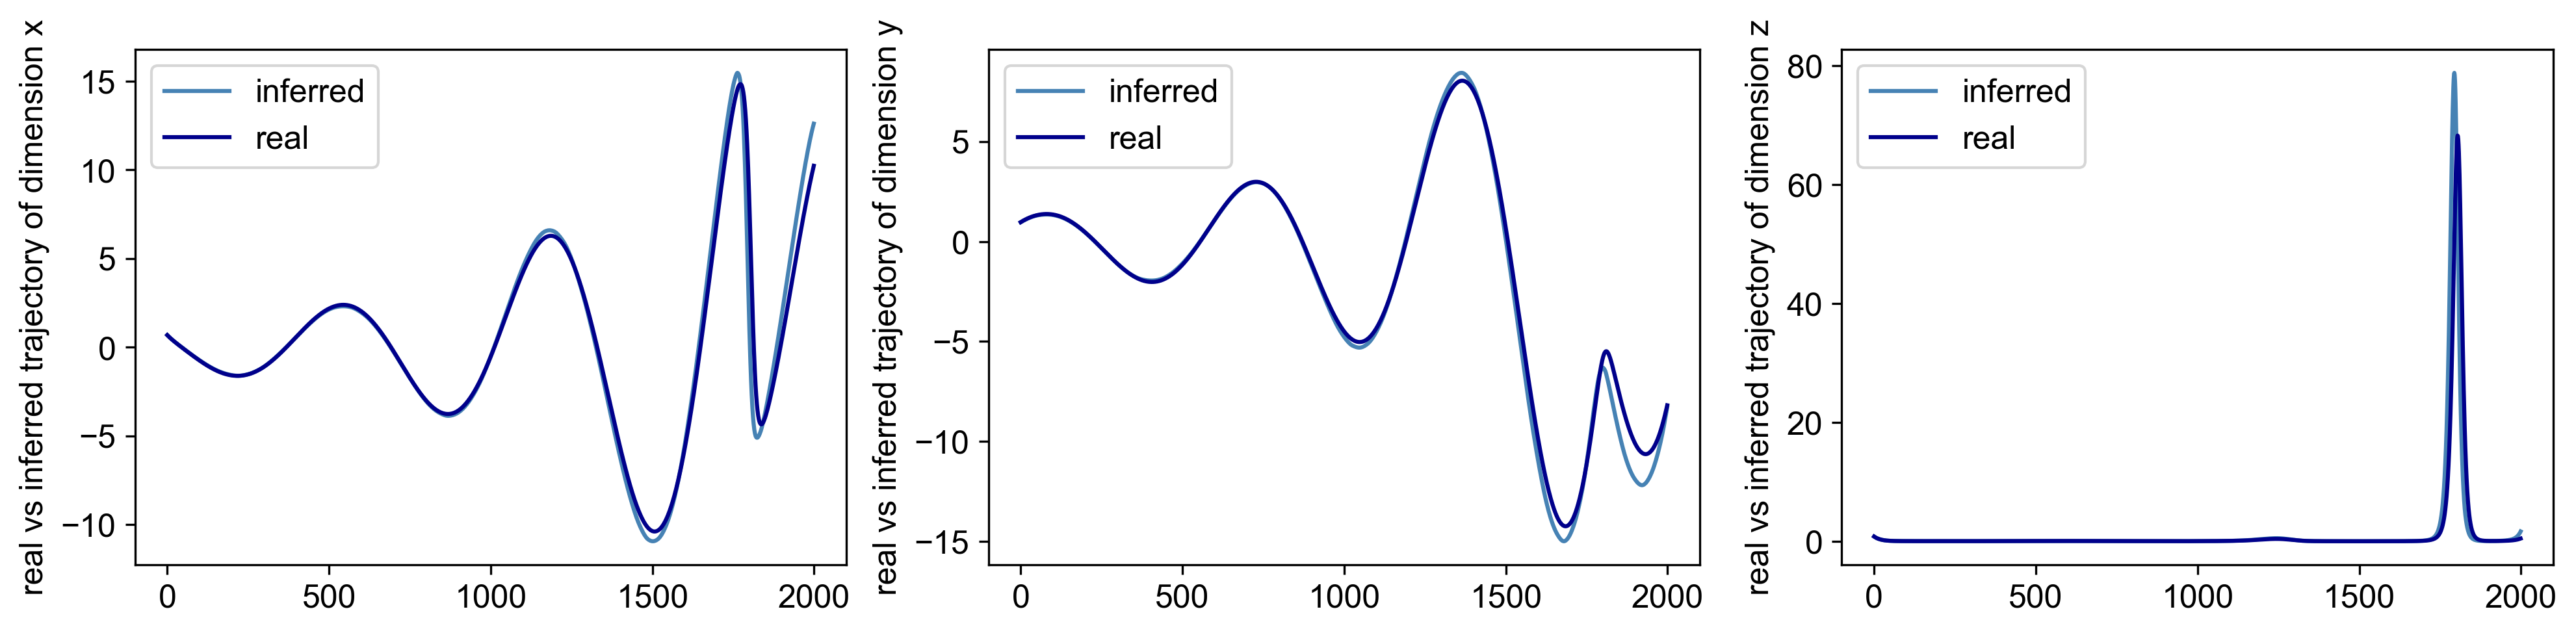

In [57]:
time1 = pd.read_csv('Rossler_determ_weighted_intensity01.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
x_tra = x_i.detach().numpy()[0:2000,0]
x_real = time1.iloc[:,0]
fig = plt.figure(figsize=(16,3.5))
ax1 = fig.add_subplot(1,3,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[1:x_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
y_tra = y_i.detach().numpy()[0:2000,0]
y_real = time1.iloc[:,1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[1:y_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
z_tra = z_i.detach().numpy()[0:2000,0]
z_real = time1.iloc[:,2]
t = np.arange(0,z_tra.shape[0])
ax3.plot(t,z_tra,c='steelblue',label="inferred")
ax3.plot(t, z_real[1:z_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension z')
plt.legend()
#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_average_trajectories.png')
plt.show()
plt.close()

In [58]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(msg_dim)])

In [59]:
bestMe = messages_over_time[-1][['e%d'%(best_message),'x1','x2','w']]

In [60]:
x_j = bestMe['x2'].values
x_i = bestMe['x1'].values

In [61]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(msg_dim)])
bestMe = messages_over_time[-1][['e%d'%(best_message),'x1','x2','w']]
coup_value = 0.5*(bestMe['x2'].values-bestMe['x1'].values)*bestMe['w'].values
temp = bestMe.iloc[:,0].values

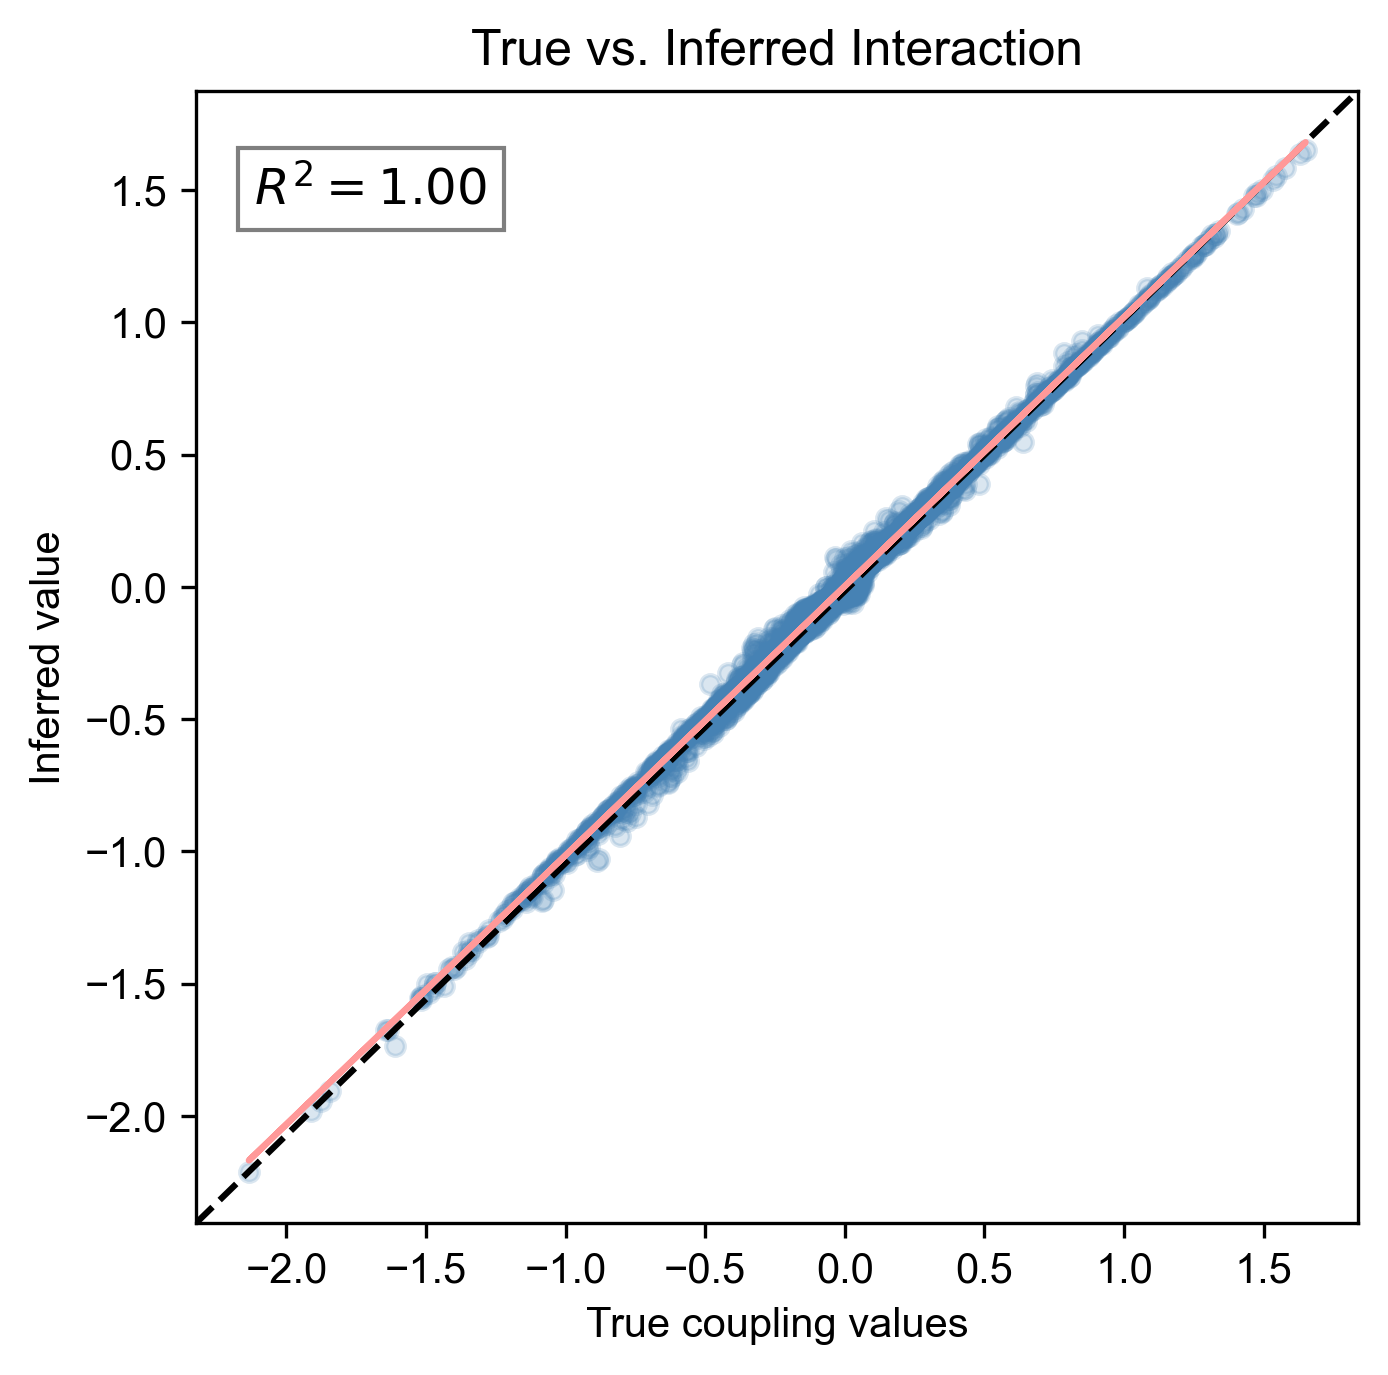

In [62]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
temp = bestMe.iloc[:,0].values
coup_value = coup_value[0:5000]
temp = temp[0:5000]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=20,c ='steelblue', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.5)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
plt.title('True vs. Inferred Interaction')
plt.xlabel("True coupling values")
plt.ylabel("Inferred value")
#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_interaction.png')
plt.show()
plt.close()

In [63]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)

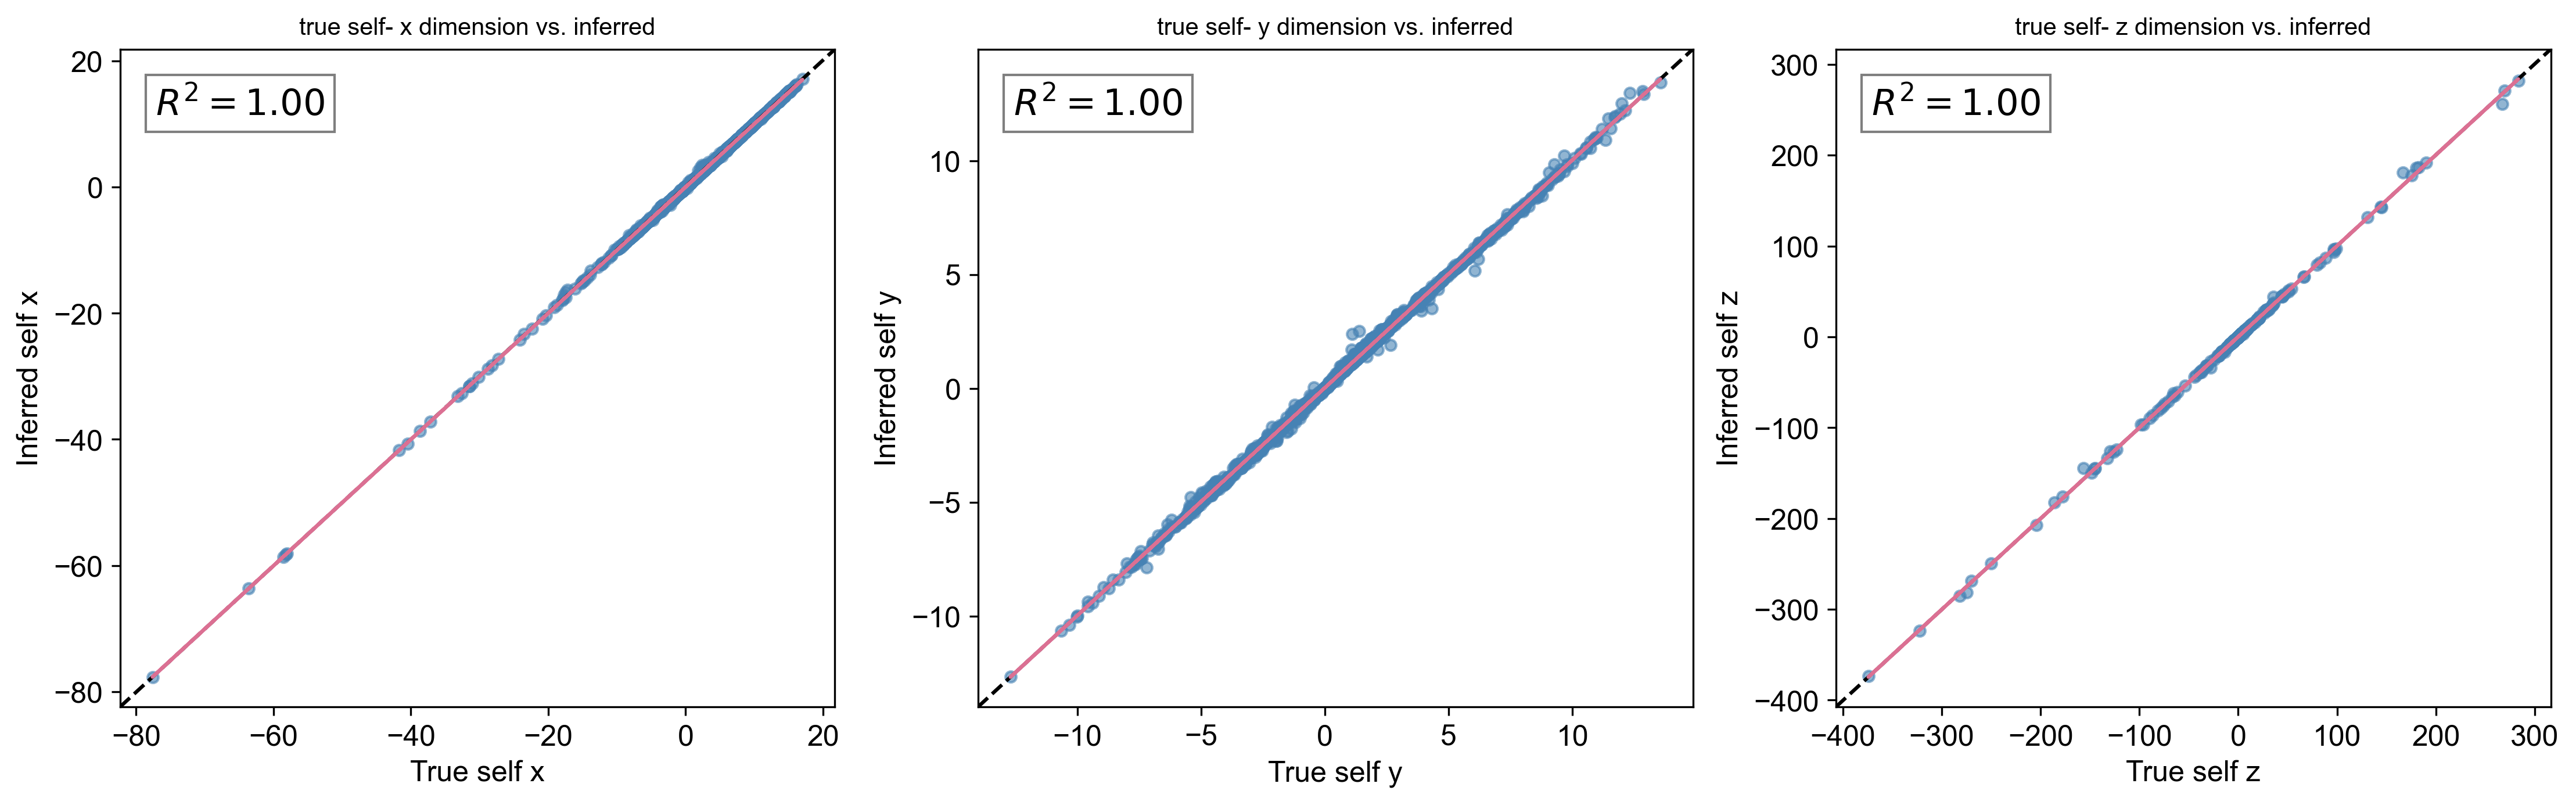

In [64]:
sx = best_selfDyn['s1'].values
sx_true = -best_selfDyn['y']-best_selfDyn['z']
sy = best_selfDyn['s2'].values
sy_true = best_selfDyn['x']+0.35*best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.2+best_selfDyn['z']*(best_selfDyn['x']-5.7)

plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true self- y dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True self y")
plt.ylabel("Inferred self y")


ax3 = fig.add_subplot(1,3,3)
plt.title("true self- z dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True self z")
plt.ylabel("Inferred self z")
plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_self.png')
plt.show()
plt.close()

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [66]:
xi = bestMe['x1'].values
xj = bestMe['x2'].values
Matrix = ElementaryFunctions_Matrix(xi,xj)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = (bestMe['e0'].values/bestMe['w'].values).reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['e0'])

/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:141: RuntimeWarning: overflow encountered in exp
  sigmoidOutput = 1/(1+np.exp(-alpha*(x-beta)))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:149: RuntimeWarning: divide by zero encountered in true_divide
  Regulation_result = (x**gamma)/(x**gamma+1)


In [67]:
X = Matrix.copy()
y = goal.copy()

In [68]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [69]:
reg1 = LassoCV(cv=5, fit_intercept=False, n_jobs=-1, max_iter=1000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9959733053205913
Best threshold: 0.008


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [70]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

In [71]:
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
sinxjMinusxi      1.000000e-10
expxixj           1.000000e-10
expxjMinusxi      7.544468e-11
xiexpxj           5.982251e-10
fracxjMinusxi     1.790590e-06
xixj              1.215389e-03
xisigmoidxj101   -2.940188e-03
sigmoidxj         5.968145e-03
xisigmoidxj      -7.132094e-03
xjMinusxi         5.029032e-01
dtype: float64


In [64]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 

In [65]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
# def terms_sort_fit(X_lib,Y_goal,intercept):
#     reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(reg.coef_)
#     if intercept == False:
#         num_params = X_lib.shape[1]
#         P = X_lib
#     else:
#         num_params = X_lib.shape[1]+1
#         constant_value = reg.intercept_
#         P = [X_lib,P]
        

#     Score = reg.score(X_lib,Y_goal)
#     yhat = reg.predict(P)
#     mse = mean_squared_error(Y_goal, yhat)
#     aic = calculate_aic(len(Y_goal), mse, num_params)
#     #print('label of function: %.3f' % time)
#     return Score, mse, aic

In [66]:
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LassoCV(cv=5, fit_intercept=intercept,  n_jobs=-1, max_iter=1000, normalize=False).fit(X_lib,Y_goal)
    coef = pd.Series(reg.coef_, index=X_lib.columns)
    if intercept == True:
        coef['constant'] = reg.intercept_
        num_params = len(coef)
    else:
        num_params = len(coef)    
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    sort = coef.sort_values()
    print(coef)
    return Score, mse, aic

In [67]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = Matrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = Matrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X)
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    if Score>0.98:
        break

0    0.507567
dtype: float64
0.9919841084141943 0.029346534589325245 -282284.4649274424 xjMinusxi


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


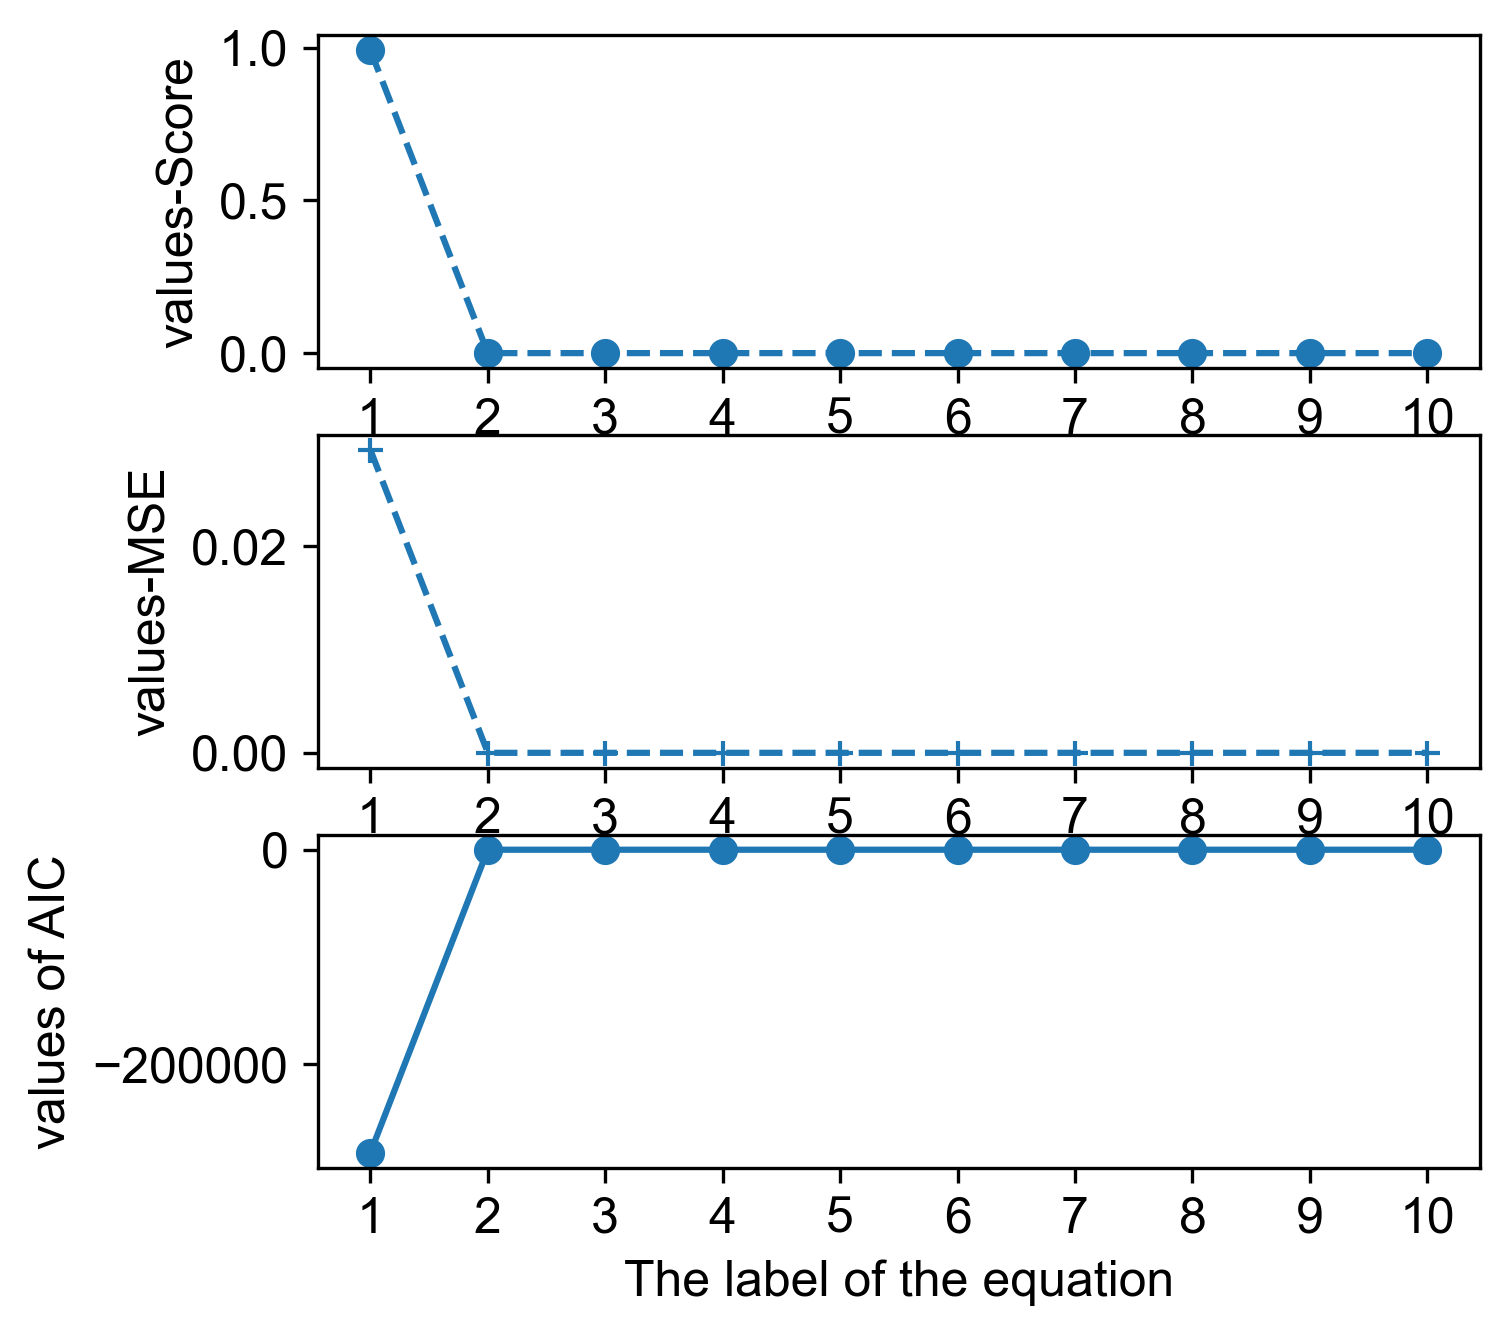

In [68]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()

In [69]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Self_func.py:291: RuntimeWarning: overflow encountered in exp
  Exp[:,j] = np.exp(TimeSeries[:,j])


In [86]:
goal = best_selfDyn['s1'].values
goal = pd.DataFrame(data = goal, columns =['s1'])

In [87]:
X = self_matrix.copy()
y = goal.copy()

In [88]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [89]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=5000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9997516251405014
Best threshold: 0.014


In [90]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [91]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
imp_cons = imp_cons.sort_values(key=abs)
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x1x3x3x3    1.000000e-10
expx1      -1.304344e-08
x1x1x3x3   -1.526142e-07
expx2      -3.725590e-06
x1x1x1      3.536006e-05
x2x2x2     -7.146364e-05
x3x3       -1.449112e-04
x1          6.417219e-04
constant   -4.690014e-02
x2         -9.838716e-01
x3         -9.867638e-01
dtype: float64


In [92]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = self_matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = self_matrix.copy()[imp_cons.index[-i]].values.reshape(-1,1)
            X = pd.DataFrame(X)
        else:
            X = pd.concat([X,tmp],axis=1)
        Score, mse, aic = terms_sort_fit(X,y,False)
    else:
        Score, mse, aic = terms_sort_fit(X,y,True)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])
    if Score>0.99867:
        break

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0   -0.856155
dtype: float64
0.5254158804843956 27.753615104282822 265871.2884588583 x3
0    -0.998153
x2   -0.999134
dtype: float64
0.9997491733501934 0.0146683085471397 -337761.2794881302 x2


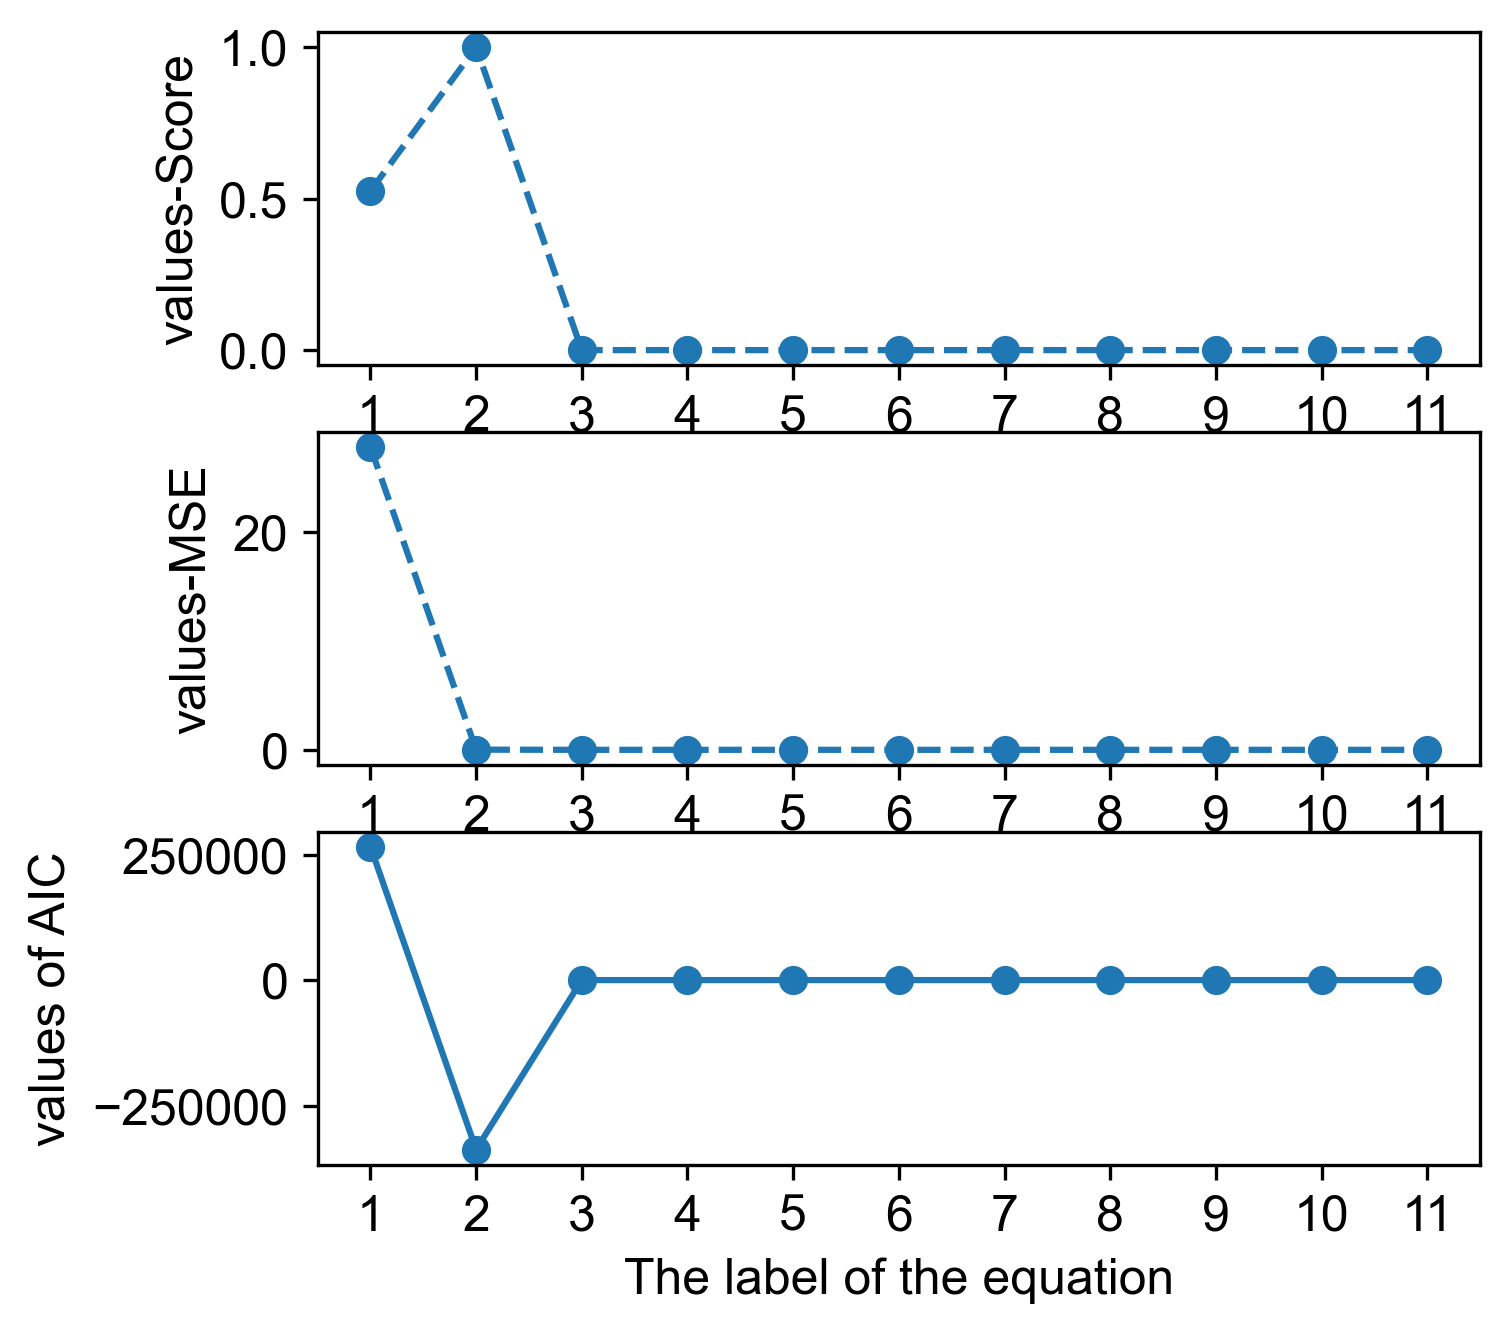

In [93]:
# Visualization
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(5,5))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()